Jax available; Jax model can be used.


Oversampling > 2x suggested for reliable results in Fresnel propagation.


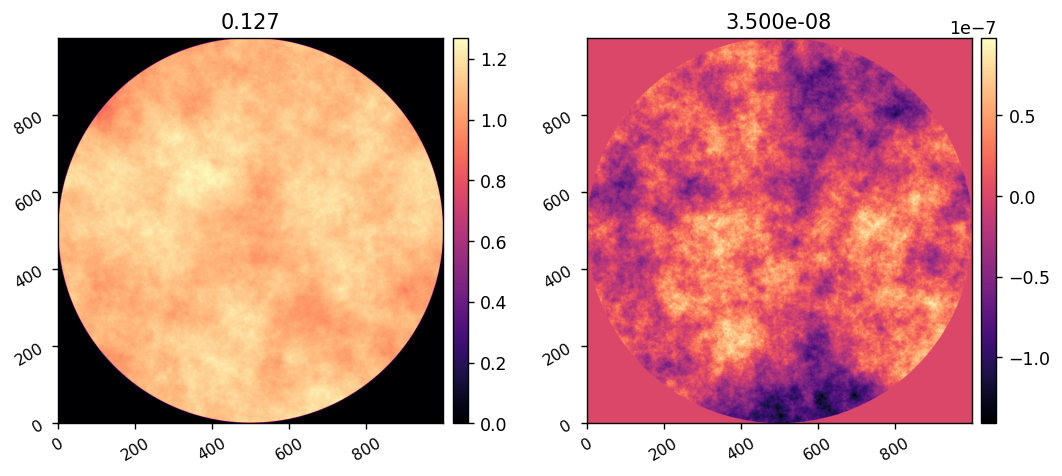

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from importlib import reload

from scipy.optimize import minimize

import scoobpsf
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.ad_efc as ad_efc
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

reload(utils)
WFE, mask = utils.generate_wfe(diam=10*u.mm,
                                npix=1000, oversample=1,
                                wavelength=650*u.nm,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*650e-9/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')


Oversampling > 2x suggested for reliable results in Fresnel propagation.


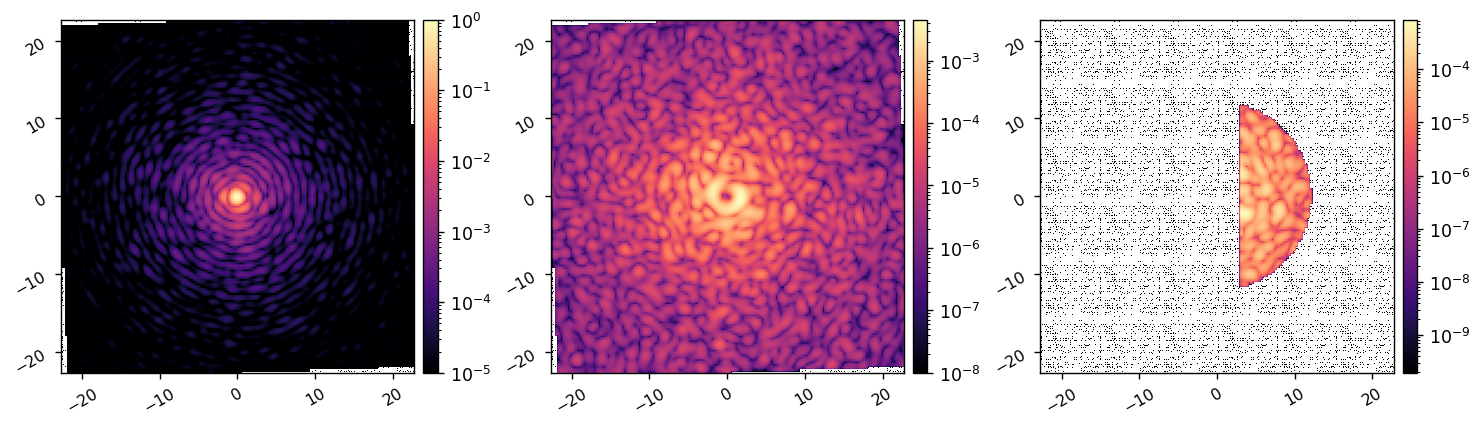

In [2]:
reload(ad_scoob)
m = ad_scoob.MODEL()
m.WFE = WFE

m.npsf = 150
m.det_rotation = 178
m.psf_pixelscale_lamD = 0.303

m.create_control_mask()

acts = np.zeros(m.Nacts)

ref_psf = m.snap(acts, use_vortex=False)
m.Imax_ref = xp.max(ref_psf)
ref_coro_im = m.snap(acts)

imshow3(ref_psf/m.Imax_ref, ref_coro_im, ref_coro_im*m.control_mask,
        pxscl=m.psf_pixelscale_lamD, lognorm=True, vmin1=1e-5, vmin2=1e-8)


0.08269376937147307 0.0 0.08269376937147307 1.0


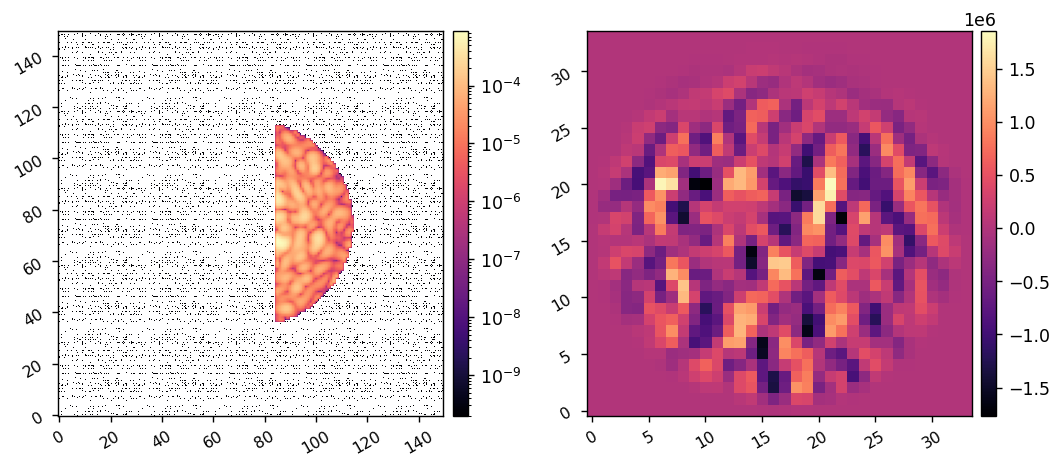

In [3]:
reload(ad_scoob)

acts = np.zeros(m.Nacts)
# acts = fits.getdata('data/ad_test_acts.fits')

E_ab = m.forward(acts) * m.control_mask
r_cond = 1e-2

del_acts = np.zeros(m.Nacts)
J, dJ_dA = ad_scoob.val_and_grad(del_acts, m, acts, E_ab, r_cond, dead_acts=None, verbose=True)

dm_grad = ad_scoob.acts_to_command(dJ_dA, m.dm_mask)
imshow2(xp.abs(E_ab)**2, dm_grad, lognorm1=True)

In [4]:

acts = np.zeros(m.Nacts)
# acts = fits.getdata('data/ad_test_acts.fits')

E_ab = m.forward(acts) * m.control_mask
r_cond = 1e-3
bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(m.Nacts)
res = minimize(ad_scoob.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(m, acts, E_ab, r_cond, None, True), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )


0.08269376937147307 0.0 0.08269376937147307 1.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.85156D+06


 This problem is unconstrained.


0.002828756025300274 2366863905.325443 0.08269376937147307 28622034323.964073
0.004645407338426831 23.125380064175154 0.08269376937147307 279.70699180019193
0.05666691944265085 1.4413645765853962 0.08269376937147307 18.11540950925408
0.4970770382766068 0.13854703767610158 0.08269376937147307 7.686480865292133
2.78134581546282 0.009990605371549242 0.08269376937147307 33.75509959275479
0.6857586921598701 0.00045054867324319426 0.08269376937147307 8.298197627811067
0.014831676936697985 2.6501156831222304e-05 0.08269376937147307 0.17967711722976365

At iterate    1    f=  1.79677D-01    |proj g|=  6.41113D+05
0.005919627759112993 3.1156886261094736e-05 0.08269376937147307 0.0719617051031046

At iterate    2    f=  7.19617D-02    |proj g|=  2.67404D+05
0.0027341116420018467 3.961115930508046e-05 0.08269376937147307 0.03354210144717119

At iterate    3    f=  3.35421D-02    |proj g|=  1.49381D+05
0.001836476013276152 4.436036876261805e-05 0.08269376937147307 0.02274459607216313

At iterate  

4.933995785887415e-05 2.1894739047425705e-07


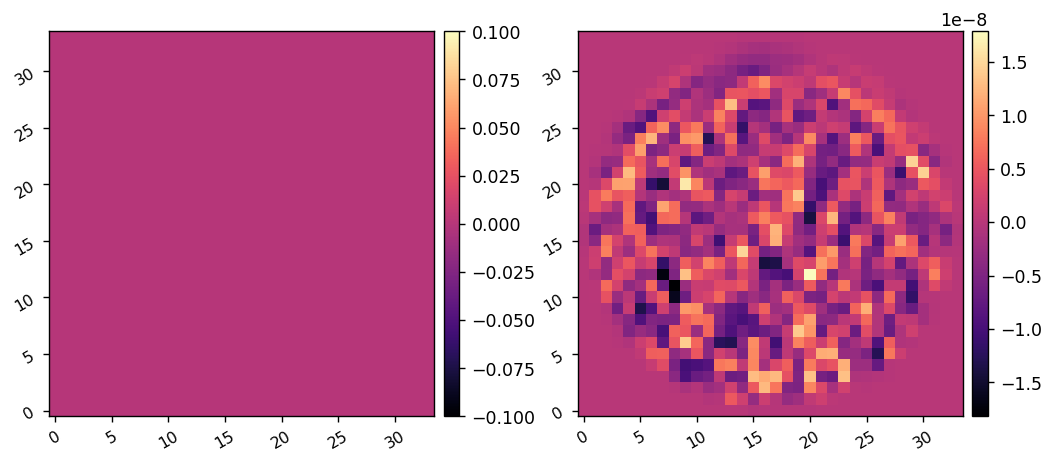

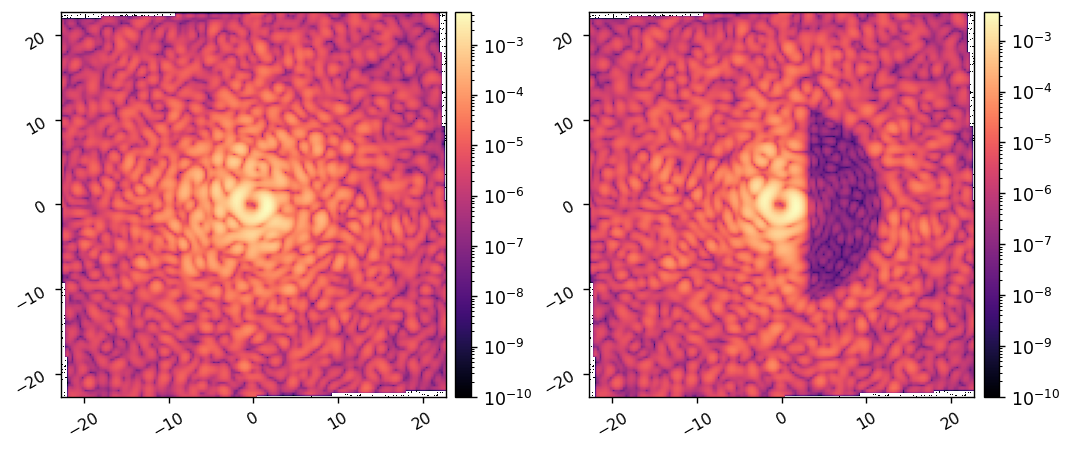

In [5]:
old_command = ad_scoob.acts_to_command(acts, m.dm_mask)
del_command = ad_scoob.acts_to_command(res.x, m.dm_mask)
old_im = m.snap(acts)
new_im = m.snap(acts + res.x)
print(xp.mean(old_im[m.control_mask]), xp.mean(new_im[m.control_mask]))

imshow2(old_command, del_command)
imshow2(old_im, new_im, lognorm=True, pxscl=m.psf_pixelscale_lamD, vmin1=1e-10, vmin2=1e-10)

In [36]:
utils.save_fits('data/ad_test_acts.fits', res.x)

Saved data to:  data/ad_test_acts.fits


In [33]:
all_ims = []
all_efs = []
all_commands = []


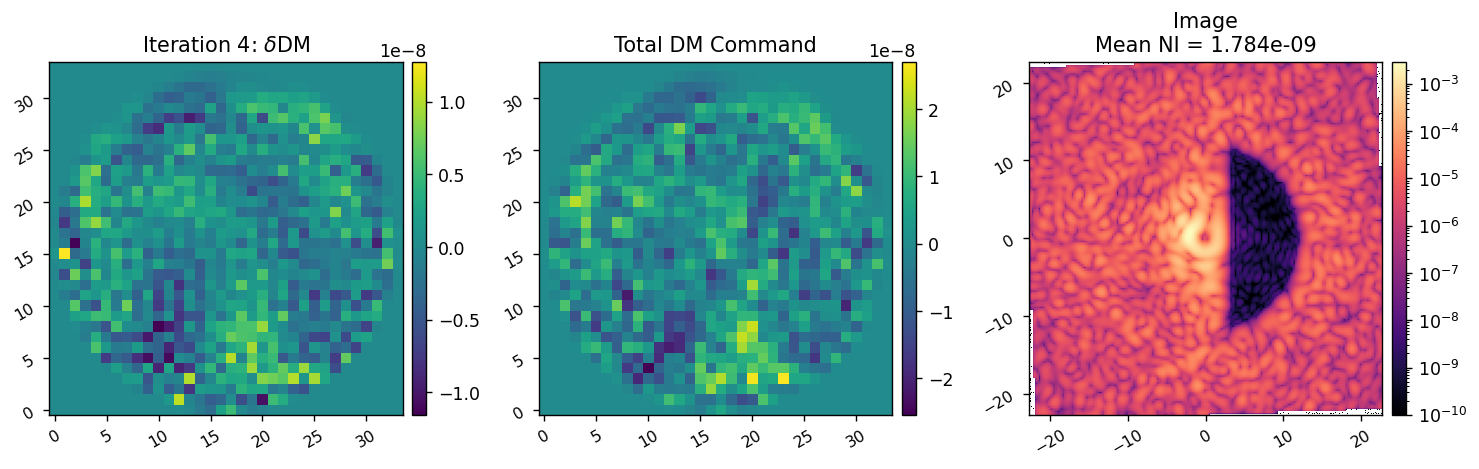

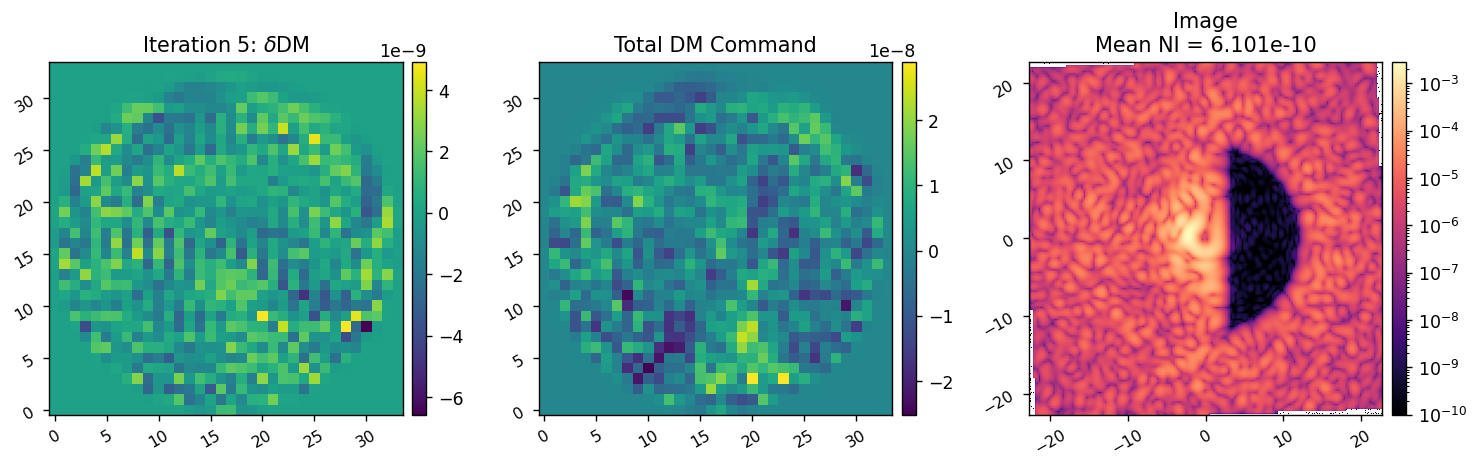

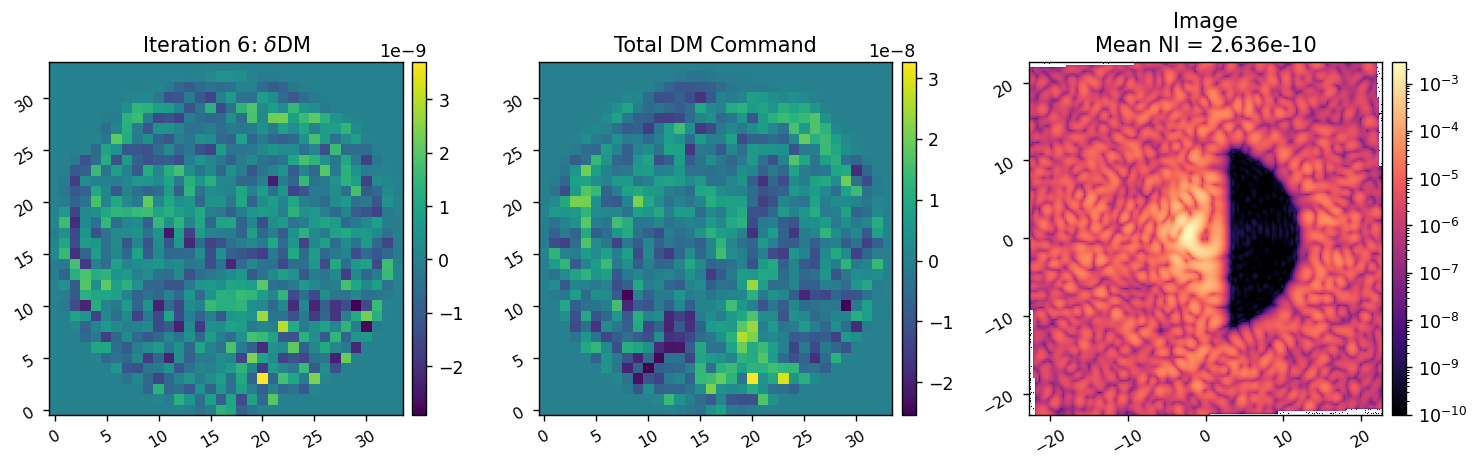

In [35]:
reload(ad_scoob)
reload(ad_efc)

r_cond = 1e-2
# r_cond = 1e-3
r_cond = 1e-4
# r_cond = 1e-5

bfgs_tol = 1e-2
bfgs_tol = 1e-3
bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':False,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

all_ims, all_efs, all_commands = ad_efc.sim(m, ad_scoob.val_and_grad,
                                            Nitr=3, 
                                            reg_cond=r_cond,
                                            bfgs_tol=bfgs_tol,
                                            bfgs_opts=bfgs_opts,
                                            gain=1,
                                            all_ims=all_ims,
                                            all_efs=all_efs,
                                            all_commands=all_commands,
                                            )

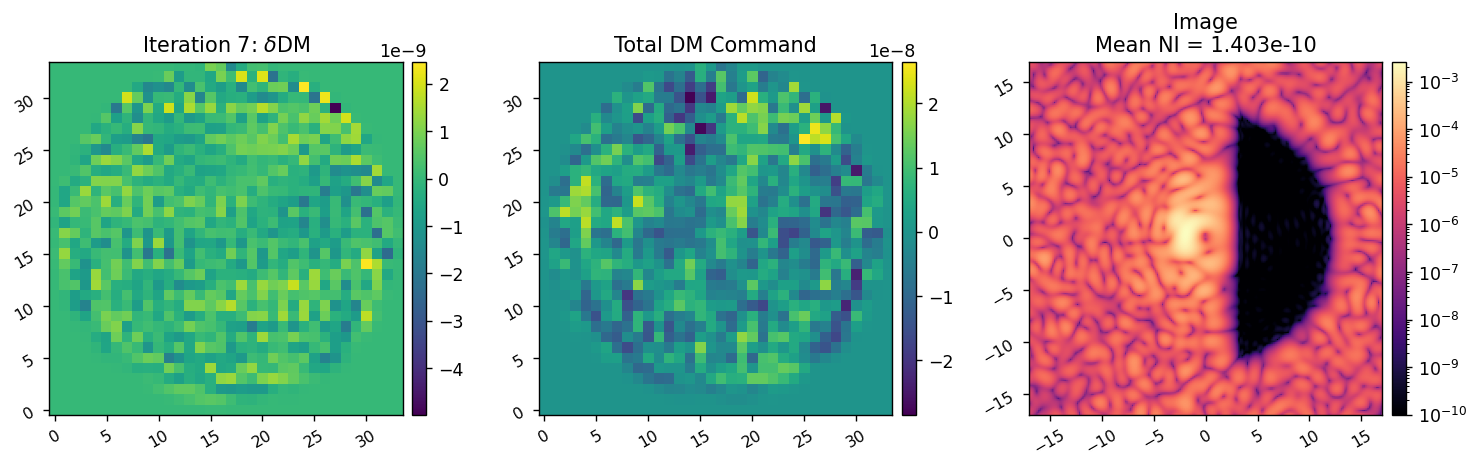

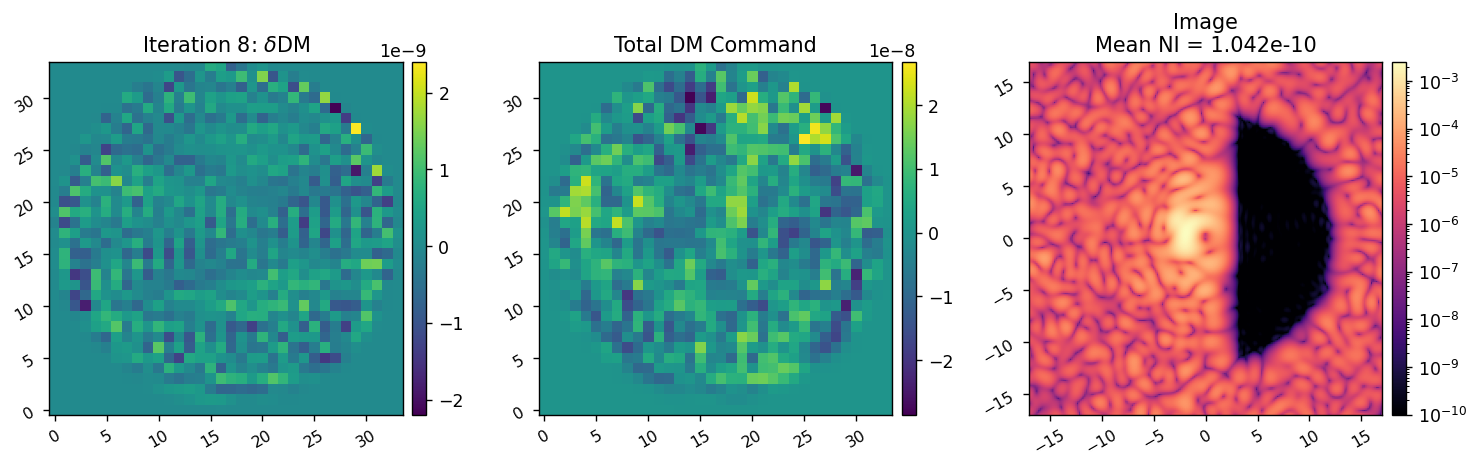

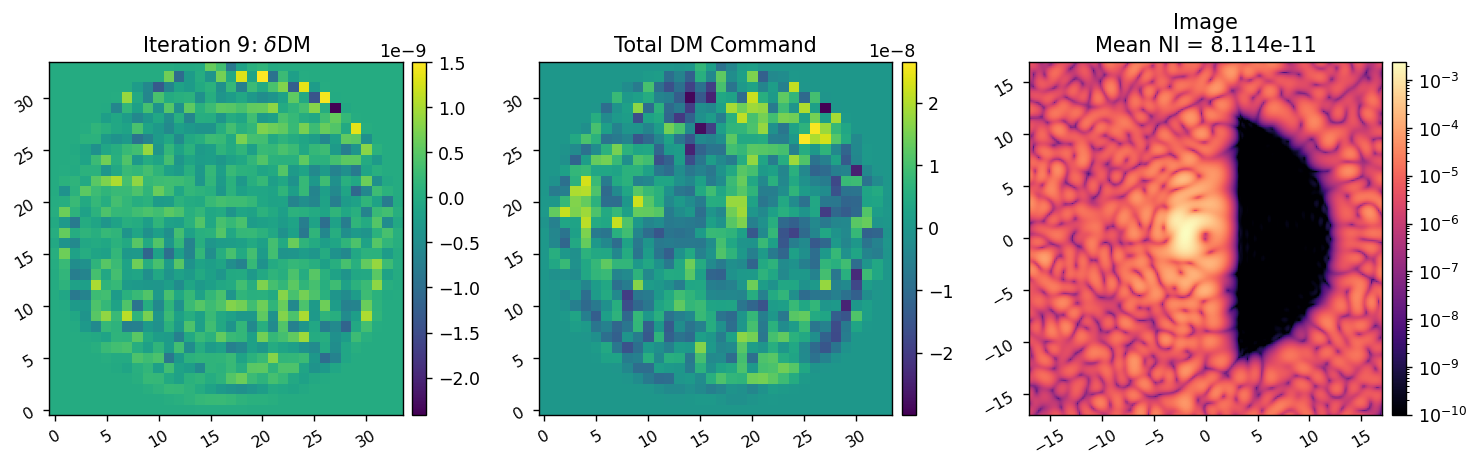

In [25]:
reload(ad_scoob)
reload(ad_efc)

r_cond = 1e-2
# r_cond = 1e-3
r_cond = 1e-4
# r_cond = 1e-5

bfgs_tol = 1e-2
bfgs_tol = 1e-3
bfgs_tol = 1e-4
bfgs_tol = 1e-5

bfgs_opts = {
    'disp':False,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

all_ims, all_efs, all_commands = ad_efc.sim(m, ad_scoob.val_and_grad,
                                            Nitr=3, 
                                            reg_cond=r_cond,
                                            bfgs_tol=bfgs_tol,
                                            bfgs_opts=bfgs_opts,
                                            gain=1, 
                                            all_ims=all_ims,
                                            all_efs=all_efs,
                                            all_commands=all_commands,
                                            )